In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import mab_gaussian as gsn

In [167]:
def poslog(x):
    return 1 if np.log(x) < 1 else np.log(x)

def gitt_approx_norm(u, t, m, c = 1/4, TAU = 1):
    #for a initially flat prior, the number of times an arm has been sampled
    #is equal to the precision of its posterior
    n = t/TAU
    approx1 = m/(np.power(poslog(m), 1.5))
    innerLog = np.power(poslog(m/n), 0.5)
    approx2 = m/(n*innerLog)
    beta = c*np.min([approx1, approx2])
    beta = np.max([1, beta])
    return u + np.sqrt(2 * np.log(beta)/n)

def coupled_gitt(T, arms, priors, armData, TAU = 1):
    K = len(arms)
    assert K == len(armData)
    assert K == len(priors)
    armData = [list(data_i) for data_i in armData]

    ar_nums = [m * t for m,t in priors]
    ar_denoms = [t for _,t in priors]

    fs_nums = [m * t for m,t in priors]
    fs_denoms = [t for _,t in priors]

    realPulls = [np.random.normal(armProbs[arm], np.sqrt(1/TAU), T) for arm in range(K)]
    fs_idx = [0 for _ in range(K)]
    ar_idx = [0 for _ in range(K)]

    horizon = T
    rews_fs = []
    rews_ar = []
    #fs_idxs = []
    #ar_idxs = []

    for arm in range(K):
        #set FS priors with data
        data_i = armData[arm]
        fs_nums[arm] += TAU * np.sum(data_i)
        fs_denoms[arm] += TAU * len(data_i)
        #run initial round robin for arms without data

        #true pull arms which do not have data (initial round robin)
        if(len(data_i) == 0):
            rew = realPulls[arm][fs_idx[arm]]
            
            fs_idx[arm] += 1
            fs_nums[arm] += rew
            fs_denoms[arm] += TAU
            rews_fs.append(rew)
            
            ar_idx[arm] += 1
            ar_nums[arm] += rew
            ar_denoms[arm] += TAU
            rews_ar.append(rew)
            
            horizon -= 1
        else: #AR data samples arms which do have data (round robin)
            rew = armData[arm].pop(0)
            ar_nums[arm] += rew
            ar_denoms[arm] += TAU

    while horizon > 0:
        fs_gitt = [gitt_approx_norm(fs_nums[arm]/fs_denoms[arm], fs_denoms[arm], horizon, TAU=TAU) for arm in range(K)]
        fs_arm = np.argmax(fs_gitt)
        fs_rew = realPulls[fs_arm][fs_idx[fs_arm]]
        fs_idx[fs_arm] += 1
        fs_nums[fs_arm] += fs_rew
        fs_denoms[fs_arm] += TAU
        rews_fs.append(fs_rew)

        realSampled = False
        while(not realSampled):
            ar_gitt = [gitt_approx_norm(ar_nums[arm]/ar_denoms[arm], ar_denoms[arm], horizon, TAU=TAU) for arm in range(K)]
            ar_arm = np.argmax(ar_gitt)
            if(len(armData[ar_arm]) > 0):
                ar_rew = armData[ar_arm].pop(0)
            else:
                ar_rew = realPulls[ar_arm][ar_idx[ar_arm]]
                ar_idx[ar_arm] += 1
                rews_ar.append(ar_rew)
                realSampled = True
            
            ar_nums[ar_arm] += ar_rew
            ar_denoms[ar_arm] += TAU

        #print("FS chose " + str(fs_arm))
        #print("AR chose " + str(ar_arm))

        #fs_idxs.append(fs_gitt)
        #ar_idxs.append(ar_gitt)

        horizon -= 1
        
    return rews_fs, rews_ar

def coupled_gitt_monotone(T, arms, priors, armData, TAU = 1):
    K = len(arms)
    assert K == len(armData)
    assert K == len(priors)
    armData = [list(data_i) for data_i in armData]

    ar_nums = [m * t for m,t in priors]
    ar_denoms = [t for _,t in priors]

    fs_nums = [m * t for m,t in priors]
    fs_denoms = [t for _,t in priors]

    realPulls = [np.random.normal(armProbs[arm], np.sqrt(1/TAU), T) for arm in range(K)]
    fs_idx = [0 for _ in range(K)]
    ar_idx = [0 for _ in range(K)]

    horizon = T
    rews_fs = []
    rews_ar = []
    fs_track_gitt = []
    ar_track_gitt = []
    fs_track_mt = [[[], []] for arm in range(K)]
    ar_track_mt = [[[], []] for arm in range(K)]
    fs_gitt_min = [1000 for arm in range(K)]

    for arm in range(K):
        #set FS priors with data
        data_i = armData[arm]
            
        #true pull arms which do not have data (initial round robin)
        if(len(data_i) == 0):
            rew = realPulls[arm][fs_idx[arm]]
            
            fs_idx[arm] += 1
            fs_nums[arm] += rew
            fs_denoms[arm] += TAU
            rews_fs.append(rew)
            
            ar_idx[arm] += 1
            ar_nums[arm] += rew
            ar_denoms[arm] += TAU
            rews_ar.append(rew)
            
            horizon -= 1
        else: 
            #FS reads all data
            for data in data_i:
                fs_nums[arm] += TAU * data
                fs_denoms[arm] += TAU
                fs_gitt_arm = gitt_approx_norm(fs_nums[arm]/fs_denoms[arm], fs_denoms[arm], horizon, TAU=TAU)
                fs_gitt_min[arm] = np.min([fs_gitt_min[arm], fs_gitt_arm])
                
            #AR data samples arms which do have data (round robin)
            rew = armData[arm].pop(0)
            ar_nums[arm] += rew
            ar_denoms[arm] += TAU


    fs_gitt = [gitt_approx_norm(fs_nums[arm]/fs_denoms[arm], fs_denoms[arm], horizon, TAU=TAU) for arm in range(K)]
    fs_gitt_min = [np.min([fs_gitt_min[i], fs_gitt[i]]) for i in range(K)]
    ar_gitt_min = [gitt_approx_norm(ar_nums[arm]/ar_denoms[arm], ar_denoms[arm], horizon, TAU=TAU) for arm in range(K)]
    
    while horizon > 0:
        #for arm in range(K):
            #print("ARM " + str(arm)+", HORIZON " + str(horizon))
            #print("FS has mean " + str(fs_nums[arm]/fs_denoms[arm]) + " precision " + str(fs_denoms[arm]) + " index=" + str(gitt_approx_norm(fs_nums[arm]/fs_denoms[arm], fs_denoms[arm], T, TAU=TAU)))
            #print("AR has mean " + str(ar_nums[arm]/ar_denoms[arm]) + " precision " + str(ar_denoms[arm]) + " index=" + str(gitt_approx_norm(ar_nums[arm]/ar_denoms[arm], ar_denoms[arm], T, TAU=TAU)))
            #print("FS_mins: " + str(fs_gitt_min) +" AR_mins: " + str(ar_gitt_min)) 
        fs_gitt = [gitt_approx_norm(fs_nums[arm]/fs_denoms[arm], fs_denoms[arm], horizon, TAU=TAU) for arm in range(K)]
        fs_gitt_min = [np.min([fs_gitt_min[i], fs_gitt[i]]) for i in range(K)]
        fs_arm = np.argmax(fs_gitt_min)
        fs_rew = realPulls[fs_arm][fs_idx[fs_arm]]
        fs_idx[fs_arm] += 1

        for arm in range(K):
            fs_track_mt[arm][0].append(fs_nums[arm]/fs_denoms[arm])
            fs_track_mt[arm][1].append(fs_denoms[arm])
        
        fs_nums[fs_arm] += fs_rew
        fs_denoms[fs_arm] += TAU
        rews_fs.append(fs_rew)

        realSampled = False
        while(not realSampled):
            ar_gitt = [gitt_approx_norm(ar_nums[arm]/ar_denoms[arm], ar_denoms[arm], horizon, TAU=TAU) for arm in range(K)]
            ar_gitt_min = [np.min([ar_gitt_min[i], ar_gitt[i]]) for i in range(K)]
            ar_arm = np.argmax(ar_gitt_min)
            ar_rew = 0
            if(len(armData[ar_arm]) > 0):
                ar_rew = armData[ar_arm].pop(0)   
            else:
                ar_rew = realPulls[ar_arm][ar_idx[ar_arm]]
                ar_idx[ar_arm] += 1
                rews_ar.append(ar_rew)
                realSampled = True

                for arm in range(K):
                    ar_track_mt[arm][0].append(ar_nums[arm]/ar_denoms[arm])
                    ar_track_mt[arm][1].append(ar_denoms[arm])
            
            ar_nums[ar_arm] += ar_rew
            ar_denoms[ar_arm] += TAU

        #print("FS chose " + str(fs_arm))
        #print("AR chose " + str(ar_arm))

        fs_track_gitt.append(fs_gitt_min)
        ar_track_gitt.append(ar_gitt_min)
        

        horizon -= 1
        
    return rews_fs, rews_ar, fs_track_gitt, ar_track_gitt, fs_track_mt, ar_track_mt

In [294]:
T = 1000
armProbs = [0.8, 0.6]
armDataAmt = [30, 1]
K = len(armProbs)
opt_arm = np.max(armProbs)
samples = 5000
plotNum = 2
#names = ["FS-AR","FS-AR (mono)"]
names = ["GITT-FS", "GITT-AR", "GITT-FS-mono","GITT-AR-mono"]
colors = ["red", "green", "black", "blue"]

  0%|          | 0/5000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Arms = [0.8, 0.6] with data = [30, 1]')

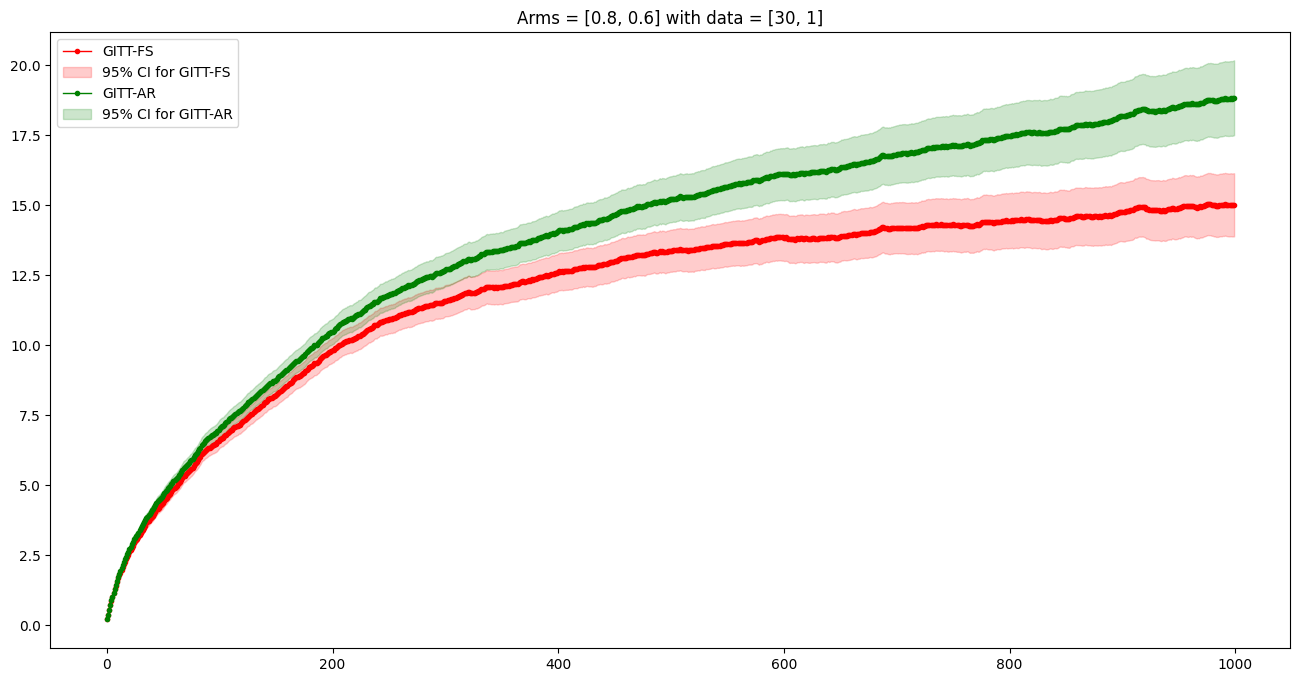

In [295]:
regret_vecs = [np.zeros((samples, T)) for _ in range(plotNum)]
TAU = 1

for i in tqdm(range(samples)):
    armData = [np.random.normal(armProbs[i], np.sqrt(1/TAU), armDataAmt[i]) for i in range(K)]

    gitt_fs, gitt_ar = coupled_gitt(T, armProbs, gsn.flat_priors(K), armData)
    #gitt_fs_mono, gitt_ar_mono, _, _, _, _ = coupled_gitt_monotone(T, armProbs, gsn.flat_priors(K), armData)

    #regret_vecs[0][i] = np.cumsum(opt_arm - gitt_fs)
    #regret_vecs[1][i] = np.cumsum(opt_arm - gitt_ar)
    #regret_vecs[2][i] = np.cumsum(opt_arm - gitt_fs_mono)
    #regret_vecs[3][i] = np.cumsum(opt_arm - gitt_ar_mono)

    regret_vecs[0][i] = np.cumsum(opt_arm - np.array(gitt_fs))
    regret_vecs[1][i] = np.cumsum(opt_arm - np.array(gitt_ar))
    #regret_vecs[0][i] = np.cumsum(np.array(gitt_fs_mono) - np.array(gitt_ar_mono))


avg_regrets = []
regret_CIs = []
for i in range(plotNum):
  avg = np.mean(regret_vecs[i], axis=0)
  avg_regrets.append(avg)
  regret_CIs.append([avg-2*np.std(regret_vecs[i],axis=0)/np.sqrt(samples),
                       avg+2*np.std(regret_vecs[i],axis=0)/np.sqrt(samples)])

c = np.arange(T)
plt.rcParams["figure.figsize"] = (16,8)
for i in range(plotNum):
    #plt.scatter(c,avg_regrets[i],label=names[i],color=colors[i])
    plt.plot(c,avg_regrets[i],'.-',label=names[i],linewidth=1,color=colors[i])
    plt.fill_between(c, regret_CIs[i][0][:],regret_CIs[i][1][:],alpha=0.2,label='95% CI for '+ names[i],color=colors[i])
random_regret = opt_arm - np.mean(armProbs)
#plt.scatter(c,c * random_regret,label="Random regret",color="black")
#plt.scatter(c,c * (opt_arm - np.min(armProbs)),label="Worst-case regret",color="brown")
plt.legend()
plt.title("Arms = " + str(armProbs) + " with data = " +str(armDataAmt))

(array([  1.,   0.,   1.,   0.,   2.,   6.,   9.,  18.,  44.,  87., 112.,
        157., 213., 326., 358., 416., 463., 477., 456., 441., 365., 292.,
        211., 157., 105.,  71.,  45.,  29.,  22.,   8.,   7.,   6.,   5.,
         11.,   5.,   9.,   2.,  12.,   6.,   8.,   4.,  11.,   3.,   8.,
          2.,   5.,   2.,   1.,   0.,   1.]),
 array([-1.25988646e+02, -1.18125160e+02, -1.10261674e+02, -1.02398188e+02,
        -9.45347018e+01, -8.66712159e+01, -7.88077299e+01, -7.09442440e+01,
        -6.30807581e+01, -5.52172722e+01, -4.73537862e+01, -3.94903003e+01,
        -3.16268144e+01, -2.37633284e+01, -1.58998425e+01, -8.03635657e+00,
        -1.72870635e-01,  7.69061530e+00,  1.55541012e+01,  2.34175872e+01,
         3.12810731e+01,  3.91445590e+01,  4.70080450e+01,  5.48715309e+01,
         6.27350168e+01,  7.05985027e+01,  7.84619887e+01,  8.63254746e+01,
         9.41889605e+01,  1.02052446e+02,  1.09915932e+02,  1.17779418e+02,
         1.25642904e+02,  1.33506390e+02,  1.41369

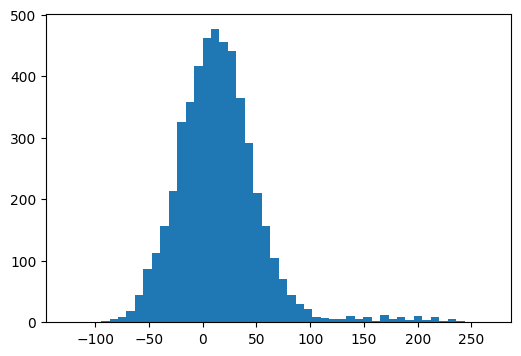

In [296]:
data = np.array(regret_vecs[0])
diff = data[:,999]
plt.rcParams["figure.figsize"] = (6,4)
plt.hist(diff, bins = 50)

In [170]:
plt.rcParams["figure.figsize"] = (6,4)
armProbs = [0.8, 0.6]
armDataAmt = [30, 1]
K = len(armProbs)
TAU = 1
T = 1000
searching = True
while searching:
    armData = [np.random.normal(armProbs[i], np.sqrt(1/TAU), armDataAmt[i]) for i in range(K)]
    gitt_fs_mono, gitt_ar_mono, fs_idxs, ar_idxs, fs_mt, ar_mt = coupled_gitt_monotone(T, armProbs, gsn.flat_priors(K), armData)
    if(np.sum(np.array(gitt_ar_mono) - np.array(gitt_fs_mono)) <= -50):
        searching = False
print(np.sum(np.array(gitt_ar_mono) - np.array(gitt_fs_mono)))

-227.31139741990333


<Figure size 1000x600 with 0 Axes>

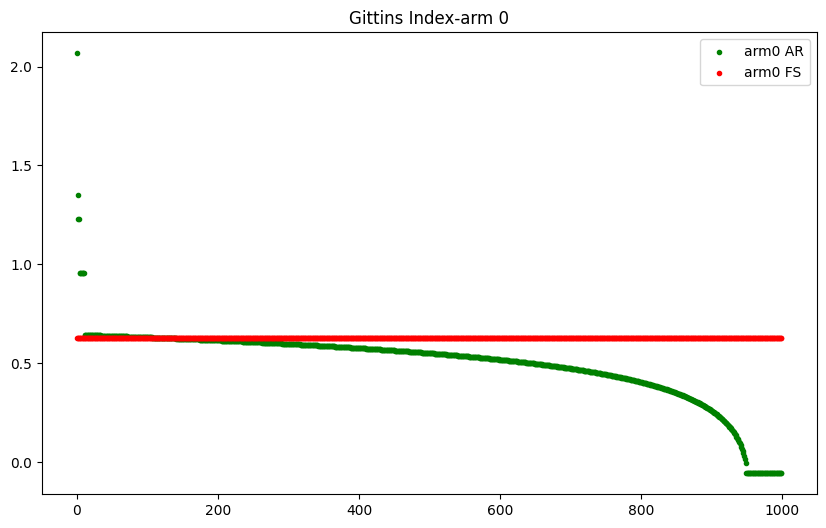

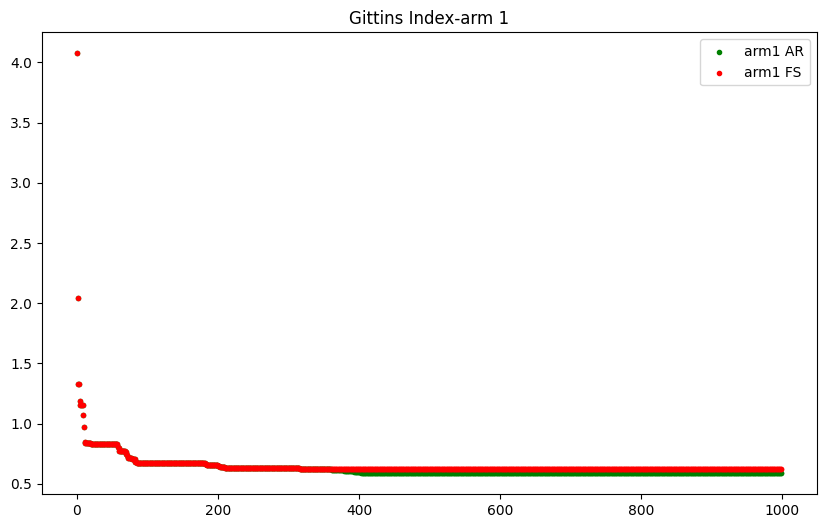

<Figure size 1000x600 with 0 Axes>

In [184]:
plt.rcParams["figure.figsize"] = (10,6)
ar_idxs = np.array(ar_idxs)
fs_idxs = np.array(fs_idxs)
plt.scatter(np.arange(T), ar_idxs[:,0], label = "arm0 AR", color = "green",marker=".")
plt.scatter(np.arange(T), fs_idxs[:,0], label = "arm0 FS", color = "red",marker=".")
plt.title("Gittins Index-arm 0")
plt.legend()
plt.figure()
plt.scatter(np.arange(T), ar_idxs[:,1], label = "arm1 AR", color = "green",marker=".")
plt.scatter(np.arange(T), fs_idxs[:,1], label = "arm1 FS", color = "red",marker=".")
plt.title("Gittins Index-arm 1")
plt.legend()
plt.figure()

<Figure size 400x300 with 0 Axes>

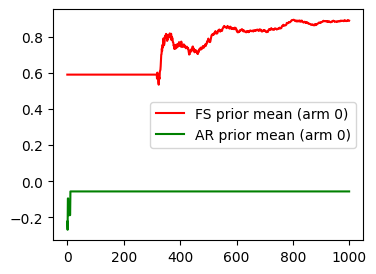

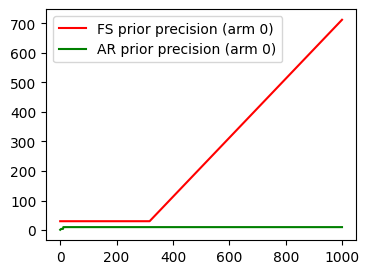

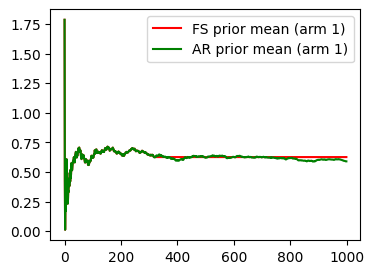

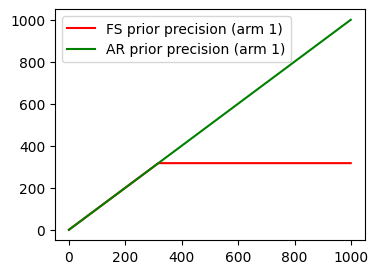

<Figure size 400x300 with 0 Axes>

In [174]:
plt.rcParams["figure.figsize"] = (4,3)
plt.plot(c, fs_mt[0][0], label = "FS prior mean (arm 0)", color = "red")
plt.plot(c, ar_mt[0][0], label = "AR prior mean (arm 0)", color = "green")
plt.legend()
plt.figure()
plt.plot(c, fs_mt[0][1], label = "FS prior precision (arm 0)", color = "red")
plt.plot(c, ar_mt[0][1], label = "AR prior precision (arm 0)", color = "green")
plt.legend()
plt.figure()
plt.plot(c, fs_mt[1][0], label = "FS prior mean (arm 1)", color = "red")
plt.plot(c, ar_mt[1][0], label = "AR prior mean (arm 1)", color = "green")
plt.legend()
plt.figure()
plt.plot(c, fs_mt[1][1], label = "FS prior precision (arm 1)", color = "red")
plt.plot(c, ar_mt[1][1], label = "AR prior precision (arm 1)", color = "green")
plt.legend()
plt.figure()

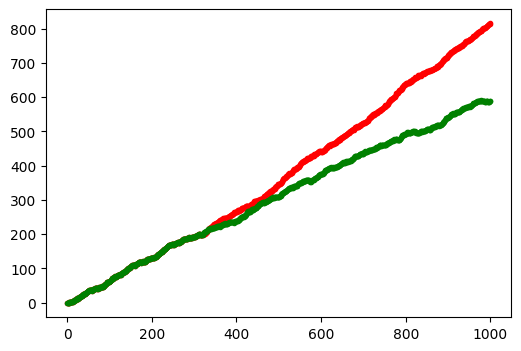

In [173]:
c = np.arange(T)
plt.plot(c,np.cumsum(gitt_fs_mono),'.-',label="monotone FS",linewidth=1,color="red")
plt.plot(c,np.cumsum(gitt_ar_mono),'.-',label="monotone AR",linewidth=1,color="green")

In [189]:
print(armData)
cumMean = np.cumsum(armData[0])/np.arange(1, 31)
print(cumMean)

[array([-0.22327499, -0.31338011,  0.25261939, -0.46488215,  1.11323626,
        0.7804861 , -0.95235081,  1.24617805,  0.04200497, -2.03979175,
        0.26936917,  0.37828189,  0.98628607,  1.17558302,  1.89224112,
        0.75425836,  1.91346419,  0.49862993,  1.33657699,  0.14850285,
       -0.54397918,  0.35290919,  3.12236646,  0.32622629, -0.02430201,
        2.57402368,  1.27905495,  0.83863274,  1.63433514, -0.62003644]), array([1.78516253])]
[-0.22327499 -0.26832755 -0.09467857 -0.18722946  0.07286368  0.19080075
  0.02749339  0.17982897  0.16451519 -0.0559155  -0.02634417  0.00737467
  0.08267555  0.16074037  0.27617375  0.30605404  0.40060758  0.40605326
  0.4550282   0.43970193  0.39285997  0.39104403  0.50979718  0.50214839
  0.48109037  0.56158781  0.58816066  0.5971061   0.63287261  0.59110898]


0.6457547376884797

In [267]:
print(gitt_approx_norm(-0.02634417, 11, 1000)) # FS monotone (lowest index)
print(ar_idxs[11,0]) # at time 11 AR reads up to minimum idx (10 data points)
print(gitt_approx_norm(-0.0559155, 10, 989))

0.6301523977298923
0.6434309681820168
0.6434309715353819
